In [1]:
import numpy as np
import mlutils as ml
import neuralnetworksbylayer as nn
import qdalda as ql
import matplotlib.pyplot as plt
%matplotlib inline
import itertools
import scipy.stats as ss
from sklearn import svm, metrics, neighbors, tree

# Final Project: A Comparison of Classifiers on Digitally Captured Handwritten Digits

*Casey Pore*

This project explores how different classifiers perform relative to each other on a data set. The data set used is a collection of digits that were hand written and captured via a digital interface. To classify the digits, we trained the data with a support vector machine, K-nearest neighbors, and decision tree algorithm. Results showed that support vector machines were superior, though all classifiers performed well.

## Introduction

Classification of handwritten digits is a classic example of applied machine learning. Traditionally, a canonical database of handwritten digits provided by MNIST have been used as the basis for comparing machine learning methods and their results [1]. In this study, we depart from the traditional MNIST dataset to focus on a similar, but more modern problem. We will investigate how machine learning methods compare when using digially captured handwritten digits. We will investigate three methods that have been discussed in class, but we have not yet had an assignment for in order to get a better understanding of how they might be tuned and applied. The methods are support vector machines (SVM), K-nearest neighbors (KNN), and Decision Trees. All three of these methods have been used on the MNIST data set before, but as sales of tablets and smartphones have soared in recent years, we wish to understand how well these previously studied methods of will perform on modern data that is captured via a digital input interface. Data will be partitioned into training, testing, and validation sets from which we will train the classifiers that are used to predict the data. After training, the models will be used to predict digits on a unique test set to draw conclusions about how well each of the techniques performed relative to each other.

[1] LeCun et al. "The MNIST Database of Handwritten Digits". [http://yann.lecun.com/exdb/mnist/]


## Data

For this study, we will be using the "Pen-Based Recognition of Handwritten Digits Data Set" available from the UCI Machine Learning Repository [2]. The Pen-Based data set is somewhat different from the MNIST data set that has been traditionally used for digit classification. The digits in the MNIST data set are represented as actual characters as they would appear to the human eye. The digits are 28x28 pixel grayscale images of handwritten digits 0-9 (and their corresponding output digit) that are used to train classifiers. In contrast, the Pen-Based data set is a vector of eight (x, y) coordinates that were sampled from a tablet, plus the correct output digit (0-9). The (x, y) coordinates are an integer value that represents a point on a 100x100 grid. The set of (x, y) coordinates represent a sampling of eight points captured over time as a user wrote a digit. The Pen-Based data set represents a different problem domain than the MNIST data set. That is, The Pen-Based data set can help us to identify a digit based on the stroke that a digital stylus takes when writing a certain digit. The MNIST data set is more useful for visual identification of digits. Our goal is to perform an investigation to see how SVM, KNN, and decistion trees perform on the Pen-Based data set.

This data set has the convenient property that it has been partitioned into training and a testing data sets. The training data set (pendigits.tra) is comprised of 30 independent writers, from which 250 samples each were taken. The testing data set (pendigits.tes) is comprised of an additional 14 independent writers, and again, 250 samples. 

First, we will read in the training and testing data sets.


[2] Lichman, M. (2013). UCI Machine Learning Repository [http://archive.ics.uci.edu/ml]. Irvine, CA: University of California, School of Information and Computer Science. [http://archive.ics.uci.edu/ml/datasets/Pen-Based+Recognition+of+Handwritten+Digits]

In [2]:
data = np.loadtxt('pendigits.tra', delimiter=',')
Xtra = data[:,:-1]
Ttra = data[:,-1:]

data = np.loadtxt('pendigits.tes', delimiter=',')
Xtes = data[:,:-1]
Ttes = data[:,-1:]

Below is an example of how a number '2' is represented in our data. If you were to connect the dots, you can see that visually it would resemble a '2'.

digit: 2.0


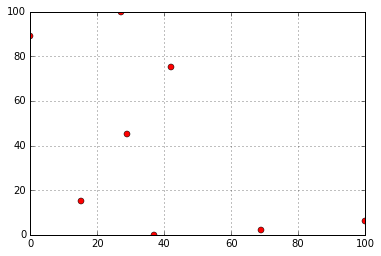

In [3]:
exampleDigit = Xtra[1,:].reshape((8,2))

print('digit:', Ttra[1,0])

plt.plot(*zip(*exampleDigit),'ro')
plt.axis([0, 100, 0, 100])
plt.grid()
plt.show()

## Methods

The first step is to train the classifiers. All three classifiers  are trained in the same way. We have borrowed the `trainValidateTestKFolds` from the `mlutils` package supplied from class and then fixed some bugs, and modified it to suit the purpose of this project. The `trainValidateTestKFolds` is familiar by now. It partitions our training data into training, validation, and test sets and returns the best results for each fold. In addition, it has been modified to return the best model for each fold as well. The `trainValidateTestKFolds` function allows us to try differnt parameter sets for the various classifier methods. How these parameters affect training is discussed for each classifier. For each parameter, the classifer is trained for 10 folds.

We have added the `getBestModel` function to extract the "best" model among the returned results. The "best" model is simply the model that achieved the highest correct predictions among all the test sets in the results. This best model is then used to predict digits for the pen digit test data to get a final evaluation of how well each classifer performs on previously unseen data.

In [4]:
labels=[0,1,2,3,4,5,6,7,8,9]

def _standardizeX(self,X):
    # if self.Xmeans is not None:
    #     result = (X - self.Xmeans) / self.XstdsFixed
    #     result[:,self.Xconstant] = 0.0
    # else:
    #     result = X
    # return result
    return X

def percentCorrect(predictedClasses, TrueClasses):
    return np.sum(TrueClasses == predictedClasses) / float(TrueClasses.shape[0]) * 100

def trainDT(X,T,parameters):
    model = tree.DecisionTreeClassifier(max_features=parameters)
    newT = T.ravel()
    model.fit(X,newT)
    return model

def evaluateDT(model,X,T):
    newT = T.ravel()
    pctCorrect = percentCorrect(model.predict(X), newT)
    return pctCorrect

def trainSVM(X,T,parameters=1):
    model = svm.SVC(C=parameters,gamma=0.0001)
    newT = T.ravel()
    model.fit(X,newT)
    return model

def evaluateSVM(model,X,T):
    newT = T.ravel()
    pctCorrect = percentCorrect(model.predict(X), newT)
    return pctCorrect

def trainKNN(X,T,parameters):
    model = neighbors.KNeighborsClassifier(parameters)
    newT = T.ravel()
    model.fit(X,newT)
    return model

def evaluateKNN(model,X,T):
    newT = T.ravel()
    pctCorrect = percentCorrect(model.predict(X), newT)
    return pctCorrect

def rowsInFold(folds,k):
    allRows = []
    for c,rows in folds.items():
        classRows, starts, stops = rows
        allRows += classRows[starts[k]:stops[k]].tolist()
    return allRows

def rowsInFolds(folds,ks):
    allRows = []
    for k in ks:
        allRows += rowsInFold(folds,k)
    return allRows

def trainValidateTestKFolds(trainf,evaluatef,X,T,parameterSets,nFolds,shuffle=False,verbose=False):
    # Randomly arrange row indices
    rowIndices = np.arange(X.shape[0])
    if shuffle:
        np.random.shuffle(rowIndices)
    
    betterFunc = max
    folds = {}
    classes = np.unique(T)
    for c in classes:
        classIndices = rowIndices[np.where(T[rowIndices,:] == c)[0]]
        nInClass = len(classIndices)
        nEach = int(nInClass / nFolds)
        starts = np.arange(0,nEach*nFolds,nEach)
        stops = starts + nEach
        stops[-1] = nInClass
        # startsStops = np.vstack((rowIndices[starts],rowIndices[stops])).T
        folds[c] = [classIndices, starts, stops]
            
    # Repeat with testFold taking each single fold, one at a time
    results = []
    bestTestEvaluation = 0
    bestModel = None
    for testFold in range(nFolds):
        # Leaving the testFold out, for each validate fold, train on remaining
        # folds and evaluate on validate fold. Collect theseRepeat with validate
        # Construct Xtest and Ttest
        rows = rowsInFold(folds,testFold)
        Xtest = X[rows,:]
        Ttest = T[rows,:]

        bestParms = None
        bestValidationEvaluation = 0
        for parms in parameterSets:
            validateEvaluationSum = 0
            
            for validateFold in range(nFolds):
                if testFold == validateFold:
                    continue
                # Construct Xtrain and Ttrain
                trainFolds = np.setdiff1d(range(nFolds), [testFold,validateFold])
                
                rows = rowsInFolds(folds,trainFolds)
                
                Xtrain = X[rows,:]
                Ttrain = T[rows,:]
                # Construct Xvalidate and Tvalidate
                rows = rowsInFold(folds,validateFold)

                Xvalidate = X[rows,:]
                Tvalidate = T[rows,:]

                model = trainf(Xtrain,Ttrain,parms)
                validateEvaluation = evaluatef(model,Xvalidate,Tvalidate)
                validateEvaluationSum += validateEvaluation
            validateEvaluation = validateEvaluationSum / (nFolds-1)
            
            if bestParms is None or validateEvaluation > bestValidationEvaluation: 
                bestParms = parms
                bestValidationEvaluation = validateEvaluation
                
            if verbose:        
                print(parms, validateEvaluation, bestValidationEvaluation)

        newXtrain = np.vstack((Xtrain,Xvalidate))
        newTtrain = np.vstack((Ttrain,Tvalidate))
        model = trainf(newXtrain,newTtrain,bestParms)
        trainEvaluation = evaluatef(model,newXtrain,newTtrain)
        testEvaluation = evaluatef(model,Xtest,Ttest)

        resultThisTestFold = [bestParms, trainEvaluation,
                              bestValidationEvaluation, testEvaluation, model]
        results.append(resultThisTestFold)
        if verbose:
            print(resultThisTestFold)
    return results

def getBestModel(results):
    bestModel = None
    bestTestEvaluation = 0
    for result in results:
        if result[3] > bestTestEvaluation:
            bestModel = result[4]
    return bestModel

def plotConfusionMatrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(10)
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    plt.tight_layout()
    plt.ylabel('True Value')
    plt.xlabel('Predicted Value')

#### Support Vector Machine

First, we run the `trainValidateTestKFolds` using our SVM classifier. The SVM classifier (and all subsequent classifiers) is an "off-the-shelf" implementaion that is available from the scikit learn project [3]. The SVM implementation that we are using utilizes a radial (Gaussian) basis function for its kernel, as initial trials showed this performed the best. Our SVM has tuned the 'gamma' parameter to be 0.0001, again this is through trial and error. The gamma parameter is a value that affects how far a "reach" a single training example has on influencing predictions. The lower a value, the farther the "reach" and the greater the influence. We initally intended to try different combinations of 'C' and 'gamma' values, but found that varying 'gamma' did not influence the 'C' parameter and 0.0001 was optimal. And so finally, the value that we vary is the 'C' parameter. The 'C' parameter is simply how much leeway to allow when classifying the training data. A value of 1 means that all values are trained exactly as they are described (no leeway). For example a 1 and a 7 may look similar, but a high value of 'C' will never allow the data for these two digits to affect training. Though as you can see in the results below, a 'C' value of 1 was the best value the majority of the time and produced the model that correctly predicted the highest percentage of digits in the test sets. In general, this classifier was very successful at predicting digits from our training set as every fold obtained over 99 percent accuracy on the training partitions.

[3] Scikit-learn: Machine Learning in Python, Pedregosa et al., JMLR 12, pp. 2825-2830, 2011.

In [5]:
#This may take a while
SVMParms = [1,.98,.95,.9,.8,.7]
SVMResult = trainValidateTestKFolds(trainSVM,evaluateSVM,Xtra,Ttra,SVMParms,10)

In [6]:
print('SVM Model\nC, train, validate, test')
err = 0
for x in SVMResult:
    err = err + x[3]
    print('{:}  \t\t    {:.3f}   {:.3f}   {:.3f}'.format(*x))
    
print("Mean test percent correct: ", err/len(SVMResult))

SVM Model
C, train, validate, test
0.8  		    99.807   99.658   99.329
1  		    99.807   99.688   99.329
1  		    99.763   99.628   99.866
1  		    99.793   99.658   99.597
0.98  		    99.807   99.628   99.732
1  		    99.778   99.568   99.866
1  		    99.793   99.642   99.463
1  		    99.778   99.613   99.597
1  		    99.778   99.613   99.597
1  		    99.746   99.582   99.873
Mean test percent correct:  99.6249096214


#### K-Nearest Neighbors

This is a straight-forward classifier that only requires us to investigate one parameter - the K number of neighbors to query when classifying a digit. Though different values of K did produce excellent results, K=3 was the best choice 66 percent of the time and even managed to obtain a 100 percent test accuracy on one of the test partions in a fold. Like SVM, KNN showed great potential, with and average percent correct prediction rate of 99.42 percent. Not quite as good as SVM, but very close. 

In [7]:
KNNParms = [1,2,3,4]
KNNResult = trainValidateTestKFolds(trainKNN,evaluateKNN,Xtra,Ttra,KNNParms,10)

In [8]:
print('K-Nearest Neighbor Model\nK, train, validate, test')
err = 0
for x in KNNResult:
    err = err + x[3]
    print('{:}  \t\t    {:.3f}   {:.3f}   {:.3f}'.format(*x))

print("Mean test percent correct: ", err/len(KNNResult))

K-Nearest Neighbor Model
K, train, validate, test
1  		    100.000   99.404   99.329
3  		    99.733   99.508   98.926
3  		    99.763   99.374   99.732
1  		    100.000   99.389   99.463
1  		    100.000   99.360   99.463
3  		    99.748   99.493   99.195
2  		    99.733   99.478   98.926
3  		    99.674   99.389   99.597
3  		    99.689   99.464   99.597
3  		    99.657   99.374   100.000
Mean test percent correct:  99.4228187919


#### Decision Trees

Our last classifier is the decision tree. The decision tree is built according to rules that are determined from the features of the digit data. For our parameter, we will be tuning the 'max_features' parameter. This parameter determines how many of the features should be included in the rule that determines which branch of the decision tree to take. So if there's 4 'max_features' then there could be up to 4 'if' statements that would need to be evaluated before descending into the next branch of the tree. This classifier is interesting in that it resulted in a wide range of parameters that perfomed the best for each fold. Ultimately though, max_features=16 performed the best. This is not surprising due to the nature of the data. Every point counts when determining the shape of a digit. This classifier performed well, but markedly worse than the previous two on the test partitions. The highest percent correct that this classifier was able to achieve was 97.315. So far is seems that SVM or KNN are better choices for classification, but it remains to be seen how well these three classifiers to on an independent batch of test data.

In [9]:
DTParms = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16]
DTResult = trainValidateTestKFolds(trainDT,evaluateDT,Xtra,Ttra,DTParms,10)

In [10]:
print('Decision Tree Model\nmax_features, train, validate, test')
err = 0
for x in DTResult:
    err = err + x[3]
    print('{:}  \t\t    {:.3f}   {:.3f}   {:.3f}'.format(*x))

print("Mean test percent correct: ", err/len(DTResult))

Decision Tree Model
max_features, train, validate, test
16  		    100.000   96.133   95.705
15  		    100.000   96.120   95.436
16  		    100.000   95.730   95.973
16  		    100.000   96.130   97.315
16  		    100.000   95.968   97.047
15  		    100.000   96.138   95.302
14  		    100.000   95.852   96.913
16  		    100.000   95.744   96.242
16  		    100.000   96.071   96.242
10  		    100.000   95.988   95.057
Mean test percent correct:  96.1231530865


## Results

Now that the classifiers have been trained we apply them to an independent test data set to evaluate how well the classifiers perform on previously unseen data. For each classifier result from the training process, we pick the model that performed the best on the training partitions and apply that model to the independent test data. We then print out the confusion matrix in raw numbers, the percent correctly predicted, and a second version of the confusion matrix as a heat map.

The way the results compare with each each other is consistent with how they did on the training data. That is, the best was SVM, then KNN, and last decision trees. For SVM is did impressively well, correctly classifying over 98 percent of the digits. It looks like it had a little of bit of trouble confusing 8 and 0, ad well as 1 and 7. This seems natural since these digits can look quite similar and can often be mistaken for each other by humans as well.  KNN also did well reaching almost 98 percent correct classification. It looks like it had the most trouble confusing 1 with 2. Perhaps there were many thinly drawn 2s in the data set, it is hard to say why there was confusion there. Finally, the decision tree did ok, but fared far worse than the previous two coming in at less than 92 percent. There were 35 instances where 1 was confused with 2 in this classifier as well. Since all the classifiers are having trouble with these two digits, I would conclude that there is something about the traing and testing sets that is off. Eitherr the ones in the training sets look like twos in the testing set, or the twos in the testing set look like ones in the training set. Regardless, the decision tree classifier performed the worst of the three.

Confusion matrix:
[[352   0   0   0   0   0   0   0  11   0]
 [  0 353  10   0   1   0   0   0   0   0]
 [  0   1 363   0   0   0   0   0   0   0]
 [  0   1   0 333   0   0   0   0   0   2]
 [  0   0   0   0 357   4   2   0   0   1]
 [  0   0   0   5   0 328   0   0   0   2]
 [  0   0   0   0   0   0 335   0   1   0]
 [  0  10   0   0   0   0   0 350   0   4]
 [  0   0   0   0   0   1   0   0 335   0]
 [  0   2   0   0   0   0   0   3   1 330]]
Percent Correct: 98.2275586049


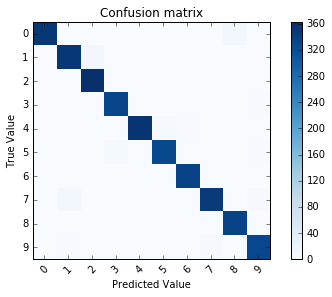

In [11]:
SVMmodel = getBestModel(SVMResult)
SVMpredicted = SVMmodel.predict(Xtes)

SVMcm = metrics.confusion_matrix(Ttes.ravel(),SVMpredicted)

print("Confusion matrix:\n%s" % SVMcm)

SVMpctCorrect = evaluateKNN(SVMmodel,Xtes,Ttes)
print('Percent Correct:', SVMpctCorrect)

plotConfusionMatrix(SVMcm)

Confusion matrix:
[[354   0   0   0   0   0   5   0   3   1]
 [  0 349  12   0   1   0   0   2   0   0]
 [  0   2 362   0   0   0   0   0   0   0]
 [  0   1   0 333   0   0   0   0   0   2]
 [  0   0   0   0 354  10   0   0   0   0]
 [  0   0   0   5   0 328   0   0   0   2]
 [  0   0   0   0   0   0 336   0   0   0]
 [  0   9   1   0   0   0   1 352   1   0]
 [  1   0   0   0   0   1   0   0 334   0]
 [  0   3   0   7   1   1   0   4   1 319]]
Percent Correct: 97.7987421384


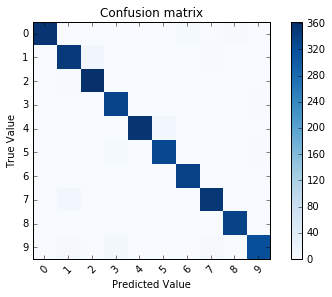

In [12]:
KNNmodel = getBestModel(KNNResult)
KNNpredicted = KNNmodel.predict(Xtes)

KNNcm = metrics.confusion_matrix(Ttes.ravel(), KNNpredicted, labels)

print("Confusion matrix:\n%s" % KNNcm)

KNNpctCorrect = evaluateKNN(KNNmodel,Xtes,Ttes)
print('Percent Correct:', KNNpctCorrect)

plotConfusionMatrix(KNNcm)

Confusion matrix:
[[335   0   3   0   1   0  11   0  13   0]
 [  0 321  37   0   0   1   2   1   0   2]
 [  0  12 345   3   0   0   2   2   0   0]
 [  0  12   2 309   0   2   4   6   0   1]
 [  0   7   0   0 347   4   0   0   0   6]
 [  0   2   0   9   3 286   1  15   2  17]
 [  1   1   4   2   0   1 324   1   2   0]
 [  0  28   2   6   0   1   4 315   2   6]
 [  5   0   0   0   0   3   2   5 321   0]
 [  0   6   0   6   2  23   0   6   0 293]]
Percent Correct: 91.3664951401


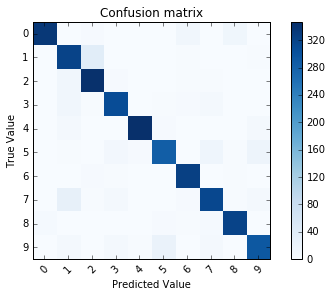

In [13]:
DTmodel = getBestModel(DTResult)
#if you want to see the decsion tree use this 
#tree.export_graphviz(DTmodel, out_file='dt.dot')

#then render on a command line with (PNG format)
#$ dot -Tpng tree.dot -o tree.png

DTpredicted = DTmodel.predict(Xtes)

DTcm = metrics.confusion_matrix(Ttes.ravel(), DTpredicted, labels)

print("Confusion matrix:\n%s" % DTcm)

DTpctCorrect = evaluateDT(DTmodel,Xtes,Ttes)
print('Percent Correct:', DTpctCorrect)

plotConfusionMatrix(DTcm)

## Conclusion

The goal of this project was to utilize some of the classification techniques that were discussed in class so that we may investigate how they perform on a novel data set. The biggest surprise to me was how accurate these classifiers were at correctly classifying digits, especially the previously unseen test set. In a previous study using this data set by Alimoglu, they acheived an accuracy of 97.8 using K=3 with KNN. This project matched that using KNN with an accuracy of 97.79874 with very little parameter tuning. Even more impressively, we were able to best Alimoglu's results using SVM, acheiving an accuracy of 98.2. However, the decision tree classifier was overly complex. I suspect this led to overfitting the data, which led to its poorer accuracy. Overall this was an eye-opening exercise that will lead to a better understanding of how to tune and apply classifiers in the future. Have a great summer!


[4] F. Alimoglu (1996) Combining Multiple Classifiers for Pen-Based Handwritten Digit Recognition, MSc Thesis, Institute of Graduate Studies in Science and Engineering, Bogazici University. 